# Intent classification

Мы разрабатываем модель классификации интентов клиентов по текстовым запросам. Для построения модели использован BERT трансформер. Модель обучена для 60 классов. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/My Drive/Shift')

In [3]:
pip install evaluate transformers

In [4]:
import random
random.seed(1234)

from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
from torch.optim import AdamW
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import get_scheduler
from tqdm.auto import tqdm
import evaluate



In [5]:
raw_datasets = load_dataset("AmazonScience/massive", "en-US")
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 11514
    })
    validation: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 2033
    })
    test: Dataset({
        features: ['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments'],
        num_rows: 2974
    })
})

In [6]:
num_labels = len(set(raw_datasets['train']['intent']))
num_labels

60

Text(0.5, 1.0, 'Intent class frequency')

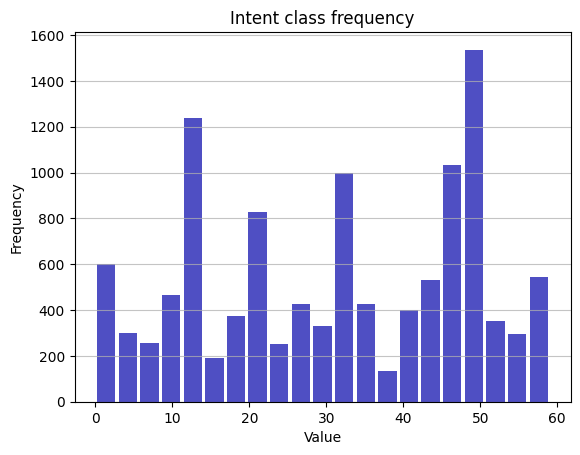

In [7]:
n, bins, patches = plt.hist(x=raw_datasets['train']['intent'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Intent class frequency')

In [8]:
raw_datasets['train'][0]

{'id': '1',
 'locale': 'en-US',
 'partition': 'train',
 'scenario': 16,
 'intent': 48,
 'utt': 'wake me up at nine am on friday',
 'annot_utt': 'wake me up at [time : nine am] on [date : friday]',
 'worker_id': '1',
 'slot_method': {'slot': [], 'method': []},
 'judgments': {'worker_id': [],
  'intent_score': [],
  'slots_score': [],
  'grammar_score': [],
  'spelling_score': [],
  'language_identification': []}}

In [9]:
class BertClassifier:
    def __init__(self, num_labels):
        self.checkpoint = "bert-base-uncased"
        self.tokenizer = AutoTokenizer.from_pretrained(self.checkpoint)
        self.data_collator = DataCollatorWithPadding(tokenizer=self.tokenizer)
        self.bert = AutoModelForSequenceClassification.from_pretrained(self.checkpoint, num_labels=num_labels)
        self.metric = evaluate.load("accuracy")

    def tokenize_data(self, data):
        def tokenize(text):
            return self.tokenizer(text['utt'], truncation = True)
        tokenized_datasets = data.map(tokenize, batched=True)
        tokenized_datasets = tokenized_datasets.rename_column("intent", "labels")
        tokenized_datasets = tokenized_datasets.select_columns(["attention_mask", "input_ids", "labels"])
        return tokenized_datasets

    def model_ft(self, tokenized_datasets, num_epochs=3):
        dataloader = DataLoader(tokenized_datasets, shuffle=True, batch_size=20, collate_fn=self.data_collator)
        optimizer = AdamW(self.bert.parameters(), lr=5e-5)
        num_training_steps = num_epochs * len(dataloader)
        lr_scheduler = get_scheduler(
            "linear",
            optimizer=optimizer,
            num_warmup_steps=0,
            num_training_steps=num_training_steps,
        )
        progress_bar = tqdm(range(num_training_steps))

        self.bert.train()
        for epoch in range(num_epochs):
            for batch in dataloader:
                batch = {k: v for k, v in batch.items()}
                outputs = self.bert(**batch)
                loss = outputs.loss
                loss.backward()

                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                progress_bar.update(1)

    def evaluate(self, tokenized_dataset):
        dataloader = DataLoader(tokenized_dataset, shuffle=True, batch_size=20, collate_fn=self.data_collator)
        self.bert.eval()
        for batch in dataloader:
            batch = {k: v for k, v in batch.items()}
            with torch.no_grad():
                outputs = self.bert(**batch)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            self.metric.add_batch(predictions=predictions, references=batch["labels"])

        return self.metric.compute()
    
    def save_model(self):
        torch.save(self.bert.state_dict(), 'BertClassifier.pth')

    def load_model(self):
        self.bert.load_state_dict(torch.load('BertClassifier.pth'))
        self.bert.eval()

In [10]:
bert = BertClassifier(num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
tokenized_datasets = bert.tokenize_data(raw_datasets)

Map:   0%|          | 0/11514 [00:00<?, ? examples/s]

Map:   0%|          | 0/2033 [00:00<?, ? examples/s]

Map:   0%|          | 0/2974 [00:00<?, ? examples/s]

In [12]:
bert.model_ft(tokenized_datasets['train'])

  0%|          | 0/1728 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [13]:
bert.evaluate(tokenized_datasets['train'])

{'accuracy': 0.95}

In [14]:
bert.evaluate(tokenized_datasets['validation'])

{'accuracy': 1.0}

In [15]:
bert.evaluate(tokenized_datasets['test'])

{'accuracy': 0.95}

In [16]:
bert.save_model()

In [17]:
bert.load_model()

Нам удалось достичь высоких показателей точности для тестовой выборки. Для дальнейшего исследования нужно добавить в модель out of scope detection - таким образом модель будет определять запросы, которые не относятся к сфере интентов, встречавшихся в обучении. 